# Autoencoders

Acknowledgment: Some pieces of code are taken from [this notebook](https://github.com/mlelarge/dataflowr/blob/master/CEA_EDF_INRIA/AE_filled_colab.ipynb).

In this notebook, you are going to build and train an autoencoder on a dataset of digit images (MNIST).

In [ ]:
# tested with pytorch 1.2.0 

# import matplotlib
# matplotlib.use('Qt4Agg') # if problem with PyQt5
import os
import matplotlib.pyplot as plt

my_seed = 0
import numpy as np
np.random.seed(my_seed)
import torch
torch.manual_seed(my_seed)
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Loading MNIST

[```torch.utils.data.DataLoader```](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) is an iterator (an object that contains a countable number of values and that can be iterated upon) which provides the following additional features:
- Batching the data (i.e. organizing the training samples in batches);
- Shuffling the data;
- Load the data in parallel using multiprocessing workers.

In addition to the batch size and a boolean indicating if data should be shuffled, it takes as input an instance of [```torch.utils.data.Dataset```](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset), which is an abstract class representing a dataset. This class has the two following methods:
- ```__len__``` which returns the number of samples in the dataset;
- ```__getitem__``` which returns a sample from the dataset given an index.

[```torchvision.datasets```](https://pytorch.org/docs/stable/torchvision/datasets.html) contains various datasets for computer vision which are subclasses of ```torch.utils.data.Dataset```, i.e. they have ```__len__``` and ```__getitem__``` methods implemented. 

In [ ]:
if not os.path.exists('data'):
    os.makedirs('data')

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=1)

test_dataset = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=1)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# show the properties of the datasets

print(train_dataset)
print('\n')

print(test_dataset)
print('\n')

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()




Image dimension:(1, 28, 28)
Image values between 0.0 and 1.0
Label: 5


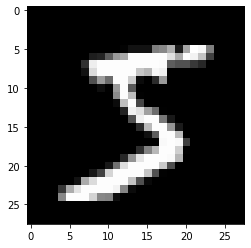

In [ ]:
# get the first item in the training set and show properties

(img, label) = train_dataset.__getitem__(0) # this is a tuple (tensor, label)
print('Image dimension:%s'% (img.numpy().shape,)) # the first dimension is the channel, a color image could have 3 channels (R,G,B)
print('Image values between %.1f and %.1f' % (np.amin(img.numpy()), np.amax(img.numpy())))
print('Label: %d' % label)

plt.imshow(img[0,:].numpy(), cmap='gray')

This is everything you need to know for this lab session. If you want to learn more about data loading in PyTorch, you can have a look to [this tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

## Activity #1 - Principal component analysis

Let's first see how principal component analysis (PCA) performs in dimensionality reduction and reconstruction. 

The projection matrix can be computed by diagonalization of the empirical covariance matrix of the data, or equivalently by singular value decomposition (SVD) of the data matrix. A quick google search outputs the following explanation about how to use SVD for PCA: https://stats.stackexchange.com/a/134283

In [ ]:
class PCA():
    def __init__(self, encoding_dim):
        self.encoding_dim = encoding_dim
        
    def train(self, x):
        self.mu = x.mean(axis=0) # empirical mean
        U,s,V = np.linalg.svd(x - self.mu, full_matrices=False) # computes X = USV (and not USV^T)
        self.V = V.T # columns of V contain the eigenvectors of the empirical covariance matrix of x
        
    def encode(self, x):
        return (x - self.mu) @ self.V[:,:self.encoding_dim]   # center data and performs dimension reduction
    
    def decode(self, z):
        return z @ self.V[:,:self.encoding_dim].T + self.mu
    
    def forward(self, x):
        z = self.encode(x)
        x = self.decode(z)
        return x

In [ ]:
# get the data from the dataset
# if you get an error because .data cannot be found, check for .train_data and .test_data

x_train = train_dataset.data.numpy().reshape(len(train_dataset), 784)/255 # 784 = 28 x 28
y_train = train_dataset.targets.numpy()
x_test = test_dataset.data.numpy().reshape(len(test_dataset), 784)/255
y_test = test_dataset.targets.numpy()

In [ ]:
# train the model

encoding_dim = 32 # latent space dimension (K)

pca = PCA(encoding_dim)

pca.train(x_train)

In [ ]:
def to_img(x):
    # convert a tensor vectorized image to a numpy image of shape 28 x 28
    if torch.is_tensor(x):
        x = x.cpu().data.numpy()
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions_PCA(model, test_loader):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784]).numpy()
    true_imgs = data
    encoded_imgs = model.encode(data)
    decoded_imgs = model.decode(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    
    n = 10
    plt.figure(figsize=(20, 10))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i,:], interpolation="nearest", 
                   vmin=0, vmax=1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[np.newaxis,i,:].T, interpolation="nearest", 
                   vmin=0, vmax=1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i,:], interpolation="nearest", 
                   vmin=0, vmax=1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

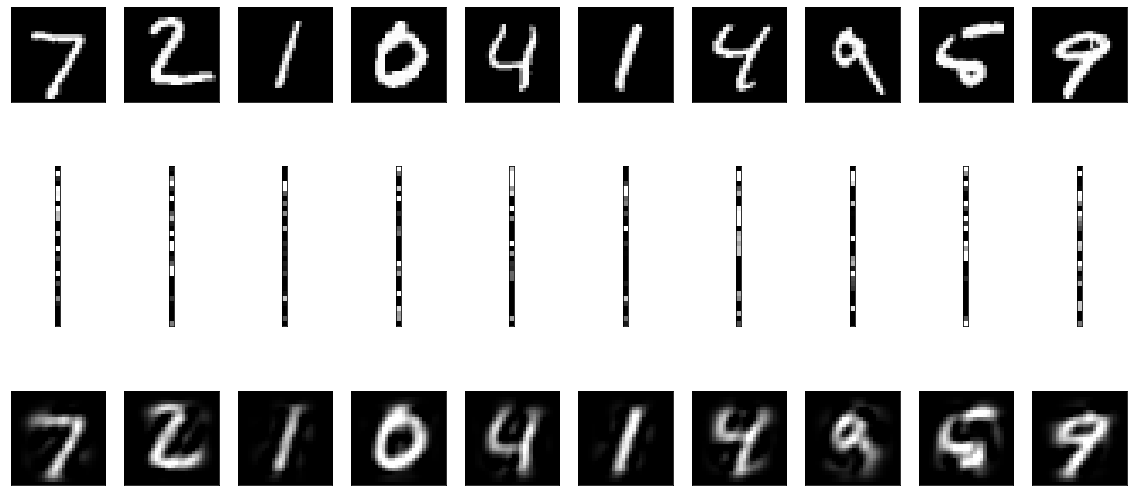

In [ ]:
# plot reconstruction

plot_reconstructions_PCA(pca, test_loader)

In [ ]:
# visualize the latent space

if encoding_dim == 2:
    z_test = pca.encode(x_test)
    cmap = plt.get_cmap('viridis', 10)
    plt.figure(figsize=[7,7])
    plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, cmap=cmap, 
                 vmin=-0.5, vmax=9.5, marker='x', s=0.8)
    plt.colorbar()
    plt.title('PCA 2D latent space')
    # each point is one image in our dataset, and the color indicates the label
    # latent space not visible in dimension 32

Increase the dimension of the latent space to 32, re-train the model and see if it improves the reconstruction quality.

## Activity #2 - Autoencoder

### Exercise 1: Defining the model

Complete the following cell to define an autoencoder where:

- The encoder:
    - takes as input a vector of dimension ```input_dim``` (784 in our case).
    - has two hidden layers with respectively 512 and 128 neurons, using a ReLU activation function.
    - has a linear output layer with ```encoding_dim``` neurons.
- The decoder:
    - takes as input a vector of dimension ```encoding_dim```.
    - has two hidden layers with respectively 128 and 512 neurons and ReLU activation functions.
    - has a non-linear output layer with ```input_dim``` neurons, using a sigmoid activation function.
    
As MNIST image pixels lie between 0 and 1 (black to white), we use a sigmoid activation function for the output layer of the decoder.

In [ ]:
class Autoencoder(nn.Module):
    
    def __init__(self, input_dim, encoding_dim):
        
        super(Autoencoder, self).__init__()
        
        ################## TODO ##################
        self.encoder_fc1 = nn.Linear(input_dim, 512)
        self.encoder_fc2 = nn.Linear(512, 128)
        self.encoder_output = nn.Linear(128, encoding_dim)
        self.relu = nn.ReLU()

        self.decoder_fc1 = nn.Linear(encoding_dim, 128)
        self.decoder_fc2 = nn.Linear(128, 512)
        self.decoder_output = nn.Linear(512, input_dim)
        self.sigmoid = nn.Sigmoid()
        ##########################################
        
    def encode(self, x):
        """
        From a data vector (MNIST image), this function 
        computes and returns the latent vector (encoding step).
        """
        ################## TODO ##################
        x = self.relu(self.encoder_fc1(x))
        x = self.relu(self.encoder_fc2(x))
        return self.encoder_output(x)
        ##########################################
    
    def decode(self, z):
        """
        From a latent vector, this function computes and 
        returns the reconstructed data vector (MNIST image) 
        (decoding step).
        """
        ################## TODO ##################
        z = self.relu(self.decoder_fc1(z))
        z = self.relu(self.decoder_fc2(z))
        return self.sigmoid(self.decoder_output(z))
        ##########################################
    
    def forward(self, x):
        """
        From a data vector (MNIST image), this function computes and 
        returns its reconstruction after encoding and decoding.
        """
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat

We instantiate the model:

In [ ]:
encoding_dim = 32

input_dim = 784 # images of 28 x 28 pixels

ae = Autoencoder(input_dim, encoding_dim)

ae = ae.to(device)

print(ae)

Autoencoder(
  (encoder_fc1): Linear(in_features=784, out_features=512, bias=True)
  (encoder_fc2): Linear(in_features=512, out_features=128, bias=True)
  (encoder_output): Linear(in_features=128, out_features=32, bias=True)
  (relu): ReLU()
  (decoder_fc1): Linear(in_features=32, out_features=128, bias=True)
  (decoder_fc2): Linear(in_features=128, out_features=512, bias=True)
  (decoder_output): Linear(in_features=512, out_features=784, bias=True)
  (sigmoid): Sigmoid()
)


### Training the model

In the following cell, you have to apply the usual recipe to train a PyTorch model. We could use ```torch.nn.MSELoss``` to define the loss function, but instead you will "manually" compute the mean squared error using ```torch.sum()```. We are here using **batch gradient descent**, meaning that we average the gradient over mini-batches of data before updating the network parameters.

In [ ]:
n_epochs = 10 # number of epochs
n_training_samples = len(train_loader) # number of training samples
learning_rate = 1e-3 # learning rate
train_loss = [] # to store the training loss after each epoch

# we use Adam, a more sophisticated version of gradient descent
# for an overview of gradient descent algorithms: https://ruder.io/optimizing-gradient-descent/
optimizer = optim.Adam(ae.parameters(), lr=learning_rate)

ae.train()

# Main training loop
for epoch in np.arange(n_epochs):

  train_acc_loss = 0  #accumulared (summed) loss over the training
  print('Epoch: {}'.format(epoch+1))
    
  # Loop over the batches in the training set
  # note that 'train_loader' provides data 'x' and labels 'y', but we do not care about labels here
  for batch_idx, (x, y) in enumerate(train_loader): 

    x = x.view([-1, 784]).to(device) # reshape the 28x28 images

    ################## TODO ##################    
    batch_size = x.shape[0]

    ae.zero_grad() # reset the gradients

    x_hat = ae(x) # do the forward

    loss = torch.sum((x_hat-x)**2) / batch_size # compute the loss

    loss.backward() # do the backward

    optimizer.step() # do the minibatch gradient descent step

    train_acc_loss += loss.item() #accumulate the loss over the train

    if(batch_idx+1) % 100 == 0:
      print('...Loss: {:.6f}'.format(loss.item()))

    #store the averaged training loss after each epoch
    train_loss.append(loss.item())
    ##########################################
        

Epoch: 1
...Loss: 48.634323
...Loss: 33.423512
...Loss: 28.114418
...Loss: 24.477180
Epoch: 2
...Loss: 22.523766
...Loss: 16.280205
...Loss: 18.269535
...Loss: 15.755301
Epoch: 3
...Loss: 15.827770
...Loss: 11.740711
...Loss: 13.710885
...Loss: 11.611032
Epoch: 4
...Loss: 12.110207
...Loss: 9.455749
...Loss: 11.515072
...Loss: 9.624170
Epoch: 5
...Loss: 10.245642
...Loss: 8.000401
...Loss: 10.042771
...Loss: 8.365798
Epoch: 6
...Loss: 8.991398
...Loss: 6.952719
...Loss: 8.981569
...Loss: 7.495041
Epoch: 7
...Loss: 8.050922
...Loss: 6.359833
...Loss: 8.265745
...Loss: 6.887947
Epoch: 8
...Loss: 7.433786
...Loss: 5.930774
...Loss: 7.607140
...Loss: 6.317647
Epoch: 9
...Loss: 6.940960
...Loss: 5.582165
...Loss: 7.105650
...Loss: 5.856595
Epoch: 10
...Loss: 6.542374
...Loss: 5.297388
...Loss: 6.732654
...Loss: 5.514143


### Testing the model

In [ ]:
def plot_reconstructions_AE(model, test_loader, device='cpu'):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784]) # the size -1 is inferred from other dimensions, shape (batch size, 784)
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encode(data)
    decoded_imgs = model.decode(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 10))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i], interpolation="nearest", 
                   vmin=0, vmax=1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[np.newaxis,i,:].T, interpolation="nearest", 
                   vmin=0, vmax=1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i], interpolation="nearest", 
                   vmin=0, vmax=1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

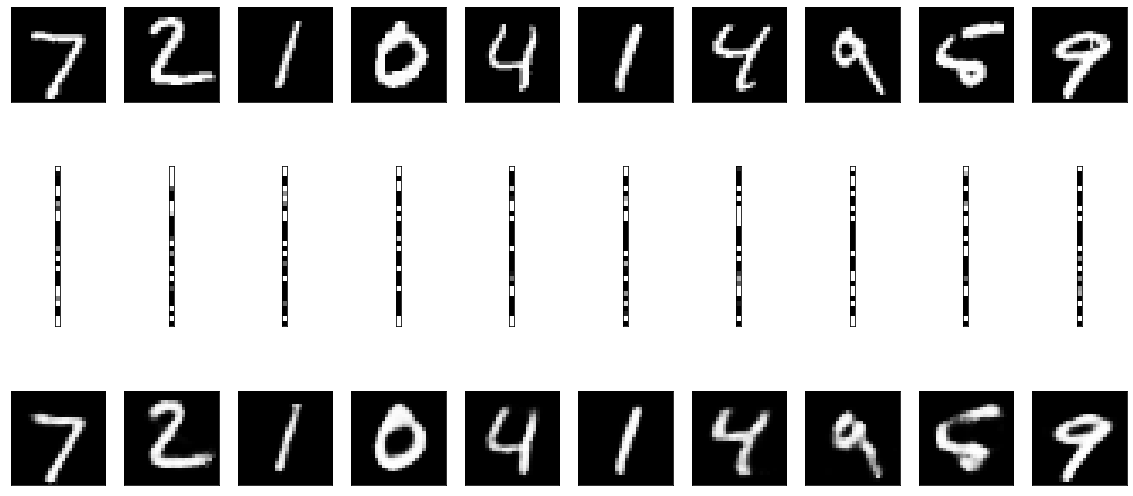

In [ ]:
# plot reconstruction

plot_reconstructions_AE(ae, test_loader, device)

In [ ]:
# visualize the latent space

if encoding_dim==2:

    z_test = np.zeros((len(test_dataset), encoding_dim))

    test_loader_batch_1 = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader_batch_1): 
            x = x.view([-1, 784]).to(device) # reshape the 28x28 images
            z_test[batch_idx,:] = ae.encode(x).cpu().numpy()
            
    # Use a discrete colormap
    cmap = plt.get_cmap('viridis', 10)
    plt.figure(figsize=[7,7])
    plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, cmap=cmap, 
                 vmin=-0.5, vmax=9.5, marker='x', s=0.8)
    plt.colorbar()
    plt.title('Autoencoder 2D latent space')

Increase the dimension of the latent space to 32, re-train the model and see if it improves the reconstruction quality.

## Activity #3 - Interpolation in the latent space

We want to interpolate between the starting and ending images below.

Text(0.5, 1.0, 'ending image')

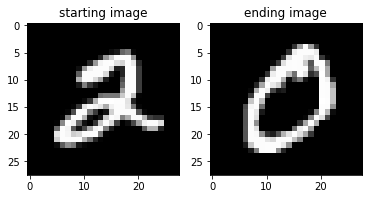

In [ ]:
id_1 = 5
(x_1, label_1) = train_dataset.__getitem__(id_1) # this is a tuple (tensor, label)
plt.imshow(x_1.numpy()[0,:], cmap='gray')

id_2 = 1
(x_2, label_2) = train_dataset.__getitem__(id_2) # this is a tuple (tensor, label)

plt.subplot(1,2,1)
plt.imshow(x_1.numpy()[0,:], cmap='gray')
plt.title('starting image')
plt.subplot(1,2,2)
plt.imshow(x_2.numpy()[0,:], cmap='gray')
plt.title('ending image')

In the following cell, build the array ```x_interp``` of shape (1, 10, 28, 28) which contains 10 interpolations between the two images. 

You can use the function ```to_img``` from ```utils.py``` which converts a tensor vectorized image to a numpy image of shape 28 x 28.

In [ ]:
x_interp = np.zeros((1, 10, 28, 28))

################## TODO ##################

# encode the two images
z_1 = ae.encode(x_1.view([-1, 784]).to(device))
z_2 = ae.encode(x_2.view([-1, 784]).to(device))

alpha_vec = np.linspace(0,1,10)
print(alpha_vec)
##########################################

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


In [ ]:
# interpolate the latent space and decode
for i, alpha in enumerate(alpha_vec):
  z = (1-alpha)*z_1 + alpha*z_2
  x_hat = ae.decode(z)
  x_interp[0,i,:,:] = to_img(x_hat)

In [ ]:
def display_digits(X, figsize=(20, 20)):
    """
    X: shape (n_i, n_j, digit_size, digit_size)
    Display an array of (n_i x n_j) images of size (digit_size x digit_size) pixels.
    """
    n_i = X.shape[0]
    n_j = X.shape[1]
    digit_size = X.shape[2]
    figure = np.zeros((digit_size * n_i, digit_size * n_j))
    
    for i in range(n_i):
        for j in range(n_j):            
            x = i * digit_size
            y = j * digit_size
            figure[x:x + digit_size, y:y + digit_size] = X[i,j,:,:]
    
    plt.figure(figsize=figsize)
    plt.imshow(figure, cmap='Greys_r')
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.show()

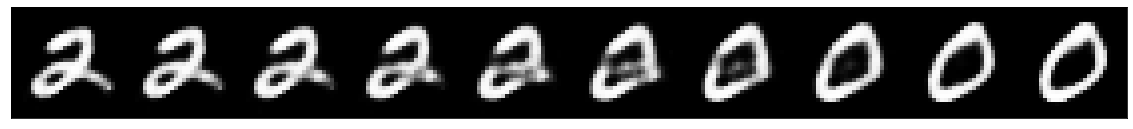

In [ ]:
display_digits(x_interp)

## Activity #4 (Bonus)

- Build a classifier using the latent space representation of MNIST images as input. Compare with a classifier that works on raw images (in terms of performance and computational time).

- Implement an autoencoder with (transposed) convolutional layers.